# Pressure-Driven Flow Between Parallel Plates

## Overview

### Questions

* What is multiparticle collision dynamics (MPCD)?
* How do I set up a pressure-driven flow simulation using MPCD?

### Objectives

* Demonstrate how to initialize MPCD particles using a **Snapshot**.
* Explain how to configure the MPCD **Integrator** with a **StreamingMethod**
  and **CollisionMethod**.
* Show how to include a confining **Geometry** in both the streaming and
  collision steps.
* Show how to apply a **BodyForce** to MPCD particles.
* Demonstrate how to run a simulation and gather data.

## Boilerplate code

In [2]:
import hoomd
import numpy
import matplotlib.pyplot as plt

## Initialization

MPCD particles are currently initialized using a `Snapshot`. We will place the
particles between two parallel plates. The parallel plates have a surface normal
in the *y* direction, and we have chosen the separation distance between them as
$2 H = 20$. The plates are infinite in the *x* and *z* directions, so
periodic boundaries will be used in these directions. We choose the extent in
the periodic directions to be $L = 25$.

The simulation box needs padded in the *y* direction to account for the
collision cells wrapping through the *y* periodic boundary. A padding of 4
cells (2 each direction) should be sufficient.

In [3]:
H = 10
L = 25
padding = 4
snapshot = hoomd.Snapshot()
snapshot.configuration.box = [L, 2*H + padding, L, 0, 0, 0]

The MPCD particle positions will be randomly drawn between the parallel plates
at a target number density $\rho = 5$. All particles will use the default
typeid (0), which we will call "A", and default mass (1). The number of
particles *N* can be computed using the density, $N = \rho V$ where $V = 2 H
L^2$ is the volume between the parallel plates.

In [4]:
density = 5
rng = numpy.random.default_rng(seed=42)

snapshot.mpcd.types = ["A"]
snapshot.mpcd.N = int(density * (2*H) * L**2)
snapshot.mpcd.position[:] = [0.5*L, H, 0.5*L] * rng.uniform(
    low=-1, high=1, size=(snapshot.mpcd.N, 3))

The particle velocities also need to be initialized for the thermostat to work
properly with the stochastic rotation dynamics (SRD) collision rule (see below).
We randomly draw them to be consistent with the Maxwell-Boltzmann distribution
for $k_{\rm B} T = 1$ and unit mass, and we force them to have zero mean.

In [5]:
kT = 1 
velocity = rng.normal(0.0, numpy.sqrt(kT), (snapshot.mpcd.N, 3))
velocity -= numpy.mean(velocity, axis=0)
snapshot.mpcd.velocity[:] = velocity

The `Snapshot` is now fully initialized, so we can use it to create a `Simulation`.
Note that this works even though there are no regular HOOMD particles in the
snapshot.

In [6]:
simulation = hoomd.Simulation(device=hoomd.device.CPU(), seed=1)
simulation.create_state_from_snapshot(snapshot)

## Configuring the MPCD integrator

We will setup an integrator for the MPCD particles that uses the SRD collision
rule with collision time $\Delta t = 0.1$, collision angle $\alpha =
130^\circ$, and a thermostat to maintain constant temperature. First, we create
the MPCD integrator with timestep $\Delta t$, and we attach an SRD collision
method to it that occurs every timestep.

In [7]:
integrator = hoomd.mpcd.Integrator(dt=0.1)
integrator.collision_method = hoomd.mpcd.collide.StochasticRotationDynamics(
    period=1, angle=130, kT=kT)

Next, we setup the streaming method. The streaming method will use bounce back
integration between parallel plates, which is defined by a geometry.

In [8]:
plates = hoomd.mpcd.geometry.ParallelPlates(separation=2*H, speed=0.0, no_slip=True)

The streaming method will also apply a constant force $f_x$ in the $x$ direction
to create a flow. For pressure-driven flow between parallel plates, the
expected velocity field has the parabolic form
$$
v_x(y) = \frac{\rho f_x H^2}{2 \mu}\left[1 - \left(\frac{y}{H}\right)^2 \right]
$$
where $\mu = 3.96$ is the dynamic viscosity of the MPCD solvent for the chosen
parameters. We will use a force $f_x = 0.004$ to give a theoretically predicted maximum
velocity of 0.25.

In [9]:
fx = 0.004
body_force = hoomd.mpcd.force.ConstantForce(force=(fx, 0, 0))

We combine all these together to make the streaming method. We stream and
collide with the same period because a constant force is easily integrated using
the velocity Verlet method, and better performance is usually achieved when
fewer streaming steps are needed.

In [10]:
integrator.streaming_method = hoomd.mpcd.stream.BounceBack(
    period=1,
    geometry=plates,
    mpcd_particle_force=body_force
)

A virtual particle filler is also needed to ensure the collision method functions
correctly with the bounce-back geometry. We can attach one to the integrator
using the same `plates` geometry we defined above.

In [11]:
filler = hoomd.mpcd.fill.GeometryFiller(
    type="A", density=density, kT=kT, geometry=plates)
integrator.virtual_particle_fillers.append(filler)

The performance of MPCD simulations benefits from periodically sorting the
particles into cell order. It is recommended to attach a tuner to the integrator
to do this. The optimal number of collision steps between sorting varies based
on the simulation and your computing hardware, but typically tens of collisions
works well.

In [12]:
integrator.solvent_sorter = hoomd.mpcd.tune.ParticleSorter(trigger=20)

Last, don't forget to attach the integrator to the simulation operations!

In [13]:
simulation.operations.integrator = integrator

## Run simulation

Now that the simulation is configured, we will first run a warmup period to
allow the system to come to steady state.

In [14]:
simulation.run(10000)

After reaching steady state, we can measure $v_x(y)$ using histogramming. We use bin spacing 0.1.

In [15]:
bin_size = 0.2
num_bins = int(2 * H / bin_size)
bin_edges = numpy.linspace(-H, H, num_bins + 1)
bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])

num_samples = 0
counts = numpy.zeros(num_bins, dtype=int)
total_velocity = numpy.zeros(num_bins, dtype=float)

Then, we run the simulation long enough to get enough independent samples with
good statistics.

In [16]:
for i in range(500):
    simulation.run(100)

    # take a snapshot of the system
    snap = simulation.state.get_snapshot()
    y = snap.mpcd.position[:, 1]
    v_x = snap.mpcd.velocity[:,0]

    # bin x-velocity using the y-position, and accumulate histograms
    y_bins = numpy.digitize(y, bin_edges) - 1
    counts += numpy.bincount(y_bins, minlength=num_bins)
    total_velocity += numpy.bincount(y_bins, weights=v_x, minlength=num_bins)
    num_samples += 1

average_velocity = numpy.zeros(num_bins, dtype=float)
numpy.divide(total_velocity, counts, out=average_velocity, where=(counts > 0));

Now, we plot our results for the average velocity profile and compare it to
the theoretical expectation. We see that the agreement is generally good, but
there is a small amount of slip near the walls. This is typical of MPCD
simulations.

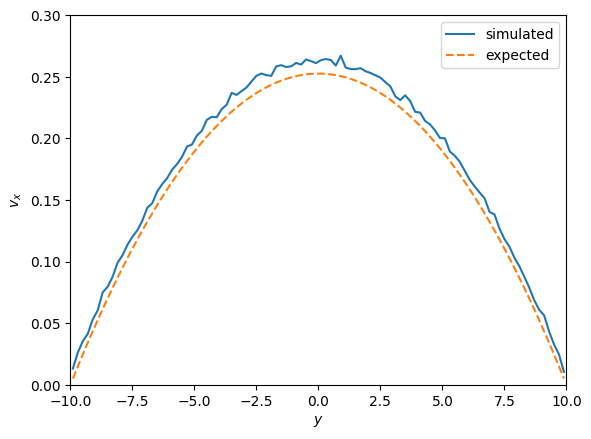

In [17]:
plt.plot(bin_centers, average_velocity, label="simulated")

viscosity = 3.96
vx_theory = ((density * fx * H**2) / (2*viscosity)) * (1 - (bin_centers/H)**2)
plt.plot(bin_centers, vx_theory, ls="--", label="expected")

plt.xlabel(r"$y$")
plt.xlim([-H, H])
plt.ylabel(r"$v_x$")
plt.ylim([0.0, 0.3])
plt.legend();